### Machine Learning model for predictions

In [134]:
# Import Libraries and load data
import pandas as pd
import numpy as np
import cryptocompare
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the yfinance dataset
df = pd.read_csv('data/yfinance-data.csv')

# Ensure the index is a DatetimeIndex
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)  # Drop rows where 'Date' is NaT
df.set_index('Date', inplace=True)


In [135]:
# DATA PROCESSING

# Check for missing values and handle them
df.isnull().sum()

# Fill missing values by forward filling
df.fillna(method='ffill', inplace=True)

# Resample data if needed (e.g., daily data)
df = df.resample('D').mean()

# Feature engineering
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Volatility'] = df['Close'].rolling(window=50).std()

# Drop any remaining NaNs after feature engineering
df.dropna(inplace=True)

# Display the preprocessed dataset
df.head()



C:\Users\THehackitect\AppData\Local\Temp\ipykernel_6744\904743364.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume,MA50,Volatility
Date,,,,,,,,
2014-11-05,3.59031,3.67109,3.59031,3.64485,3.64485,2855540.0,4.031132,0.346141
2014-11-06,3.64214,3.66741,3.61875,3.64956,3.64956,2461750.0,4.002952,0.316910
2014-11-07,3.64967,3.66196,3.55499,3.55737,3.55737,2417010.0,3.980395,0.307351
2014-11-08,3.55665,3.57875,3.53233,3.55626,3.55626,1508220.0,3.964965,0.308918
2014-11-09,3.55484,3.63730,3.54694,3.63146,3.63146,1873830.0,3.951865,0.308894


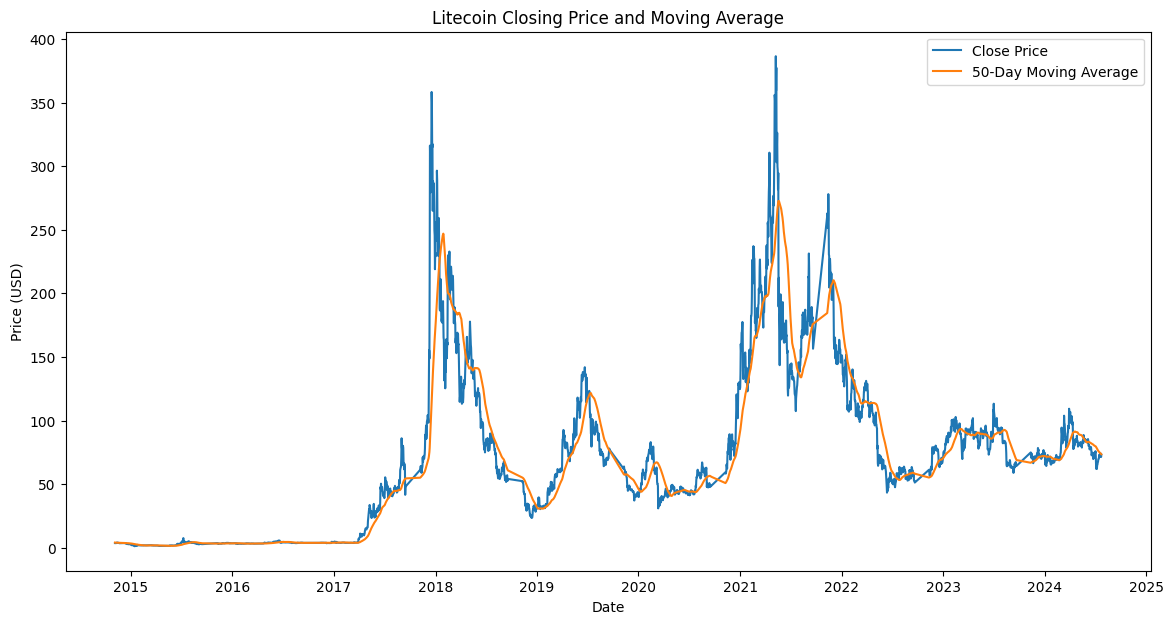

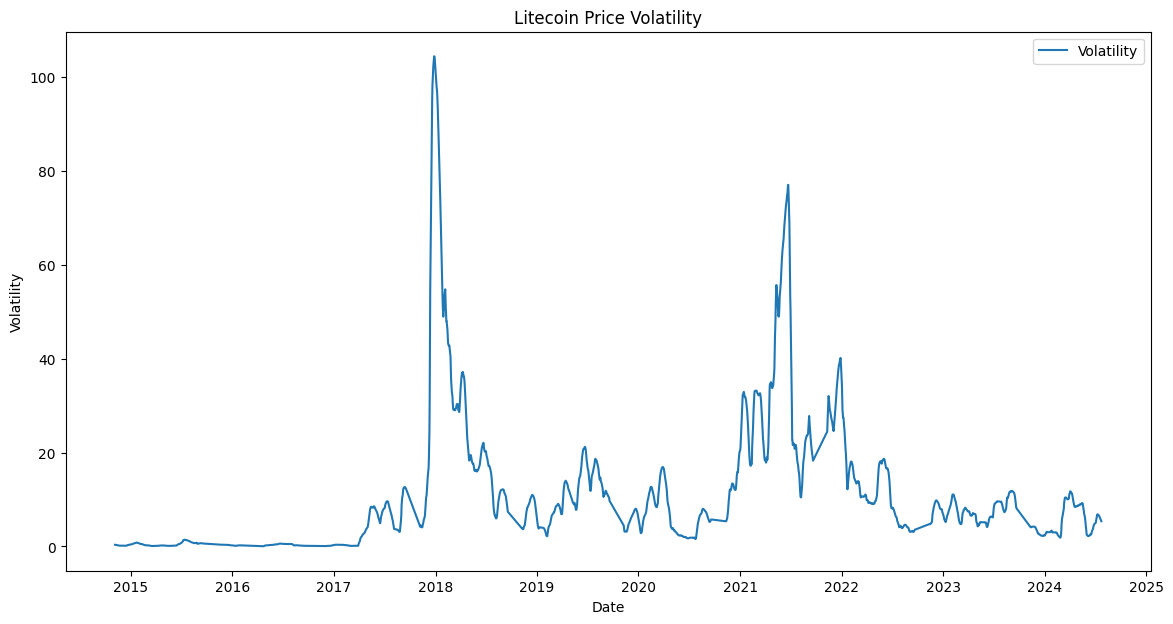

In [136]:
# DATA VISUALIZATION

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50-Day Moving Average')
plt.title('Litecoin Closing Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot the volatility
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='Volatility')
plt.title('Litecoin Price Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [137]:
# PREPARE DATA FOR LSTM MODEL
from sklearn.preprocessing import MinMaxScaler

# Separate scaler for the features
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df[['MA50', 'Volatility']])

# Separate scaler for the target variable
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(df[['Close']])

# Prepare data for LSTM model
def prepare_data(features, target, n_lags):
    X, y = [], []
    for i in range(len(features) - n_lags):
        X.append(np.hstack((features[i:i+n_lags], target[i:i+n_lags])))
        y.append(target[i+n_lags])
    return np.array(X), np.array(y)

n_lags = 50
X, y = prepare_data(scaled_features, scaled_target, n_lags)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Display the shapes of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2439, 50, 3), (610, 50, 3), (2439, 1), (610, 1))

c:\Users\THehackitect\Desktop\traderx\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0166 - val_loss: 3.1134e-04
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0025 - val_loss: 3.5572e-04
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0016 - val_loss: 3.8569e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0012 - val_loss: 2.4545e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.7713e-04 - val_loss: 2.1946e-04
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011 - val_loss: 3.9974e-04
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 8.5606e-04 - val_loss: 1.6081e-04
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.0616e-04 - val_loss: 1.4664e-04
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.8287e-04 - val_loss: 3.3056e-04
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0010 - val_loss: 1.5769e-04
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.9529e-04 - val_loss: 1.4113e-04

Model saved to lstm_model.h5


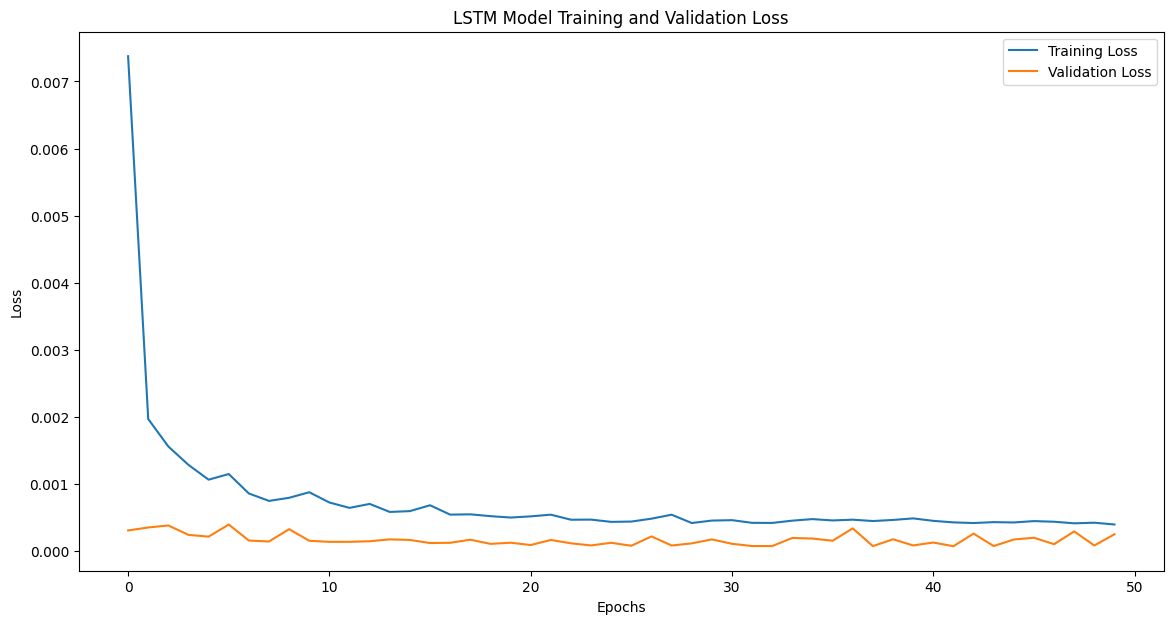

In [138]:
# BUILD AND TRAIN LSTM MODEL
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lags, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save the model to a file
model.save('lstm_model.h5')
print("Model saved to lstm_model.h5")

# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


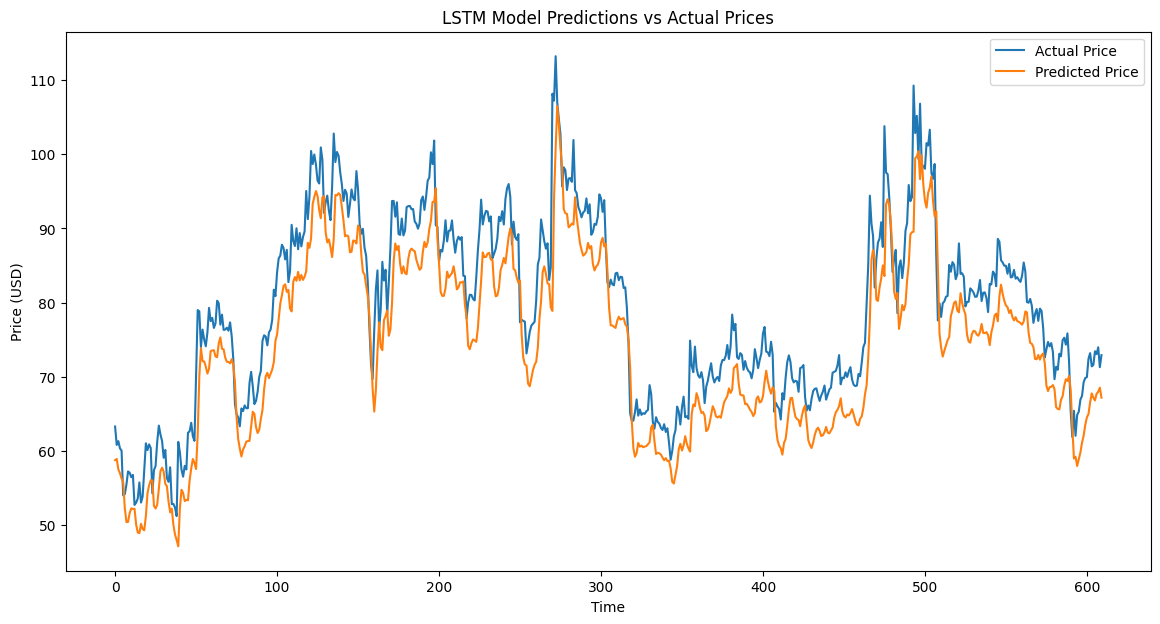

In [139]:
# EVALUATE LSTM MODEL
# Predict on test data
y_pred = model.predict(X_test)

# Reshape y_test and y_pred for inverse transformation
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform the predictions and actual values using the target scaler
y_test_inverse = scaler_target.inverse_transform(y_test_reshaped)
y_pred_inverse = scaler_target.inverse_transform(y_pred_reshaped)

# Flatten the results for plotting
y_test_inverse = y_test_inverse.flatten()
y_pred_inverse = y_pred_inverse.flatten()

# Plot the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Price')
plt.plot(y_pred_inverse, label='Predicted Price')
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [140]:
# DEVELOPE A TRADING STRATEGY USING REINFORCEMENT LEARNING
import gym
from stable_baselines3 import PPO

class TradingEnv(gym.Env):
    def __init__(self, df):
        self.df = df
        self.current_step = 0
        self.balance = 10000  # Initial capital
        self.positions = []
        self.balance_history = []
        self.position_history = [0] * len(df)
        self.action_space = gym.spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(df.shape[1],), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.positions = []
        self.balance_history = [self.balance]
        self.position_history = [0] * len(self.df)
        return self._next_observation()

    def step(self, action):
        self.current_step += 1

        if action == 0:  # Buy
            self.positions.append(self.df['Close'].iloc[self.current_step])
        elif action == 2 and self.positions:  # Sell
            bought_price = self.positions.pop(0)
            self.balance += self.df['Close'].iloc[self.current_step] - bought_price

        self.balance_history.append(self.balance)
        self.position_history[self.current_step] = len(self.positions)
        
        reward = self.balance - 10000
        done = self.current_step >= len(self.df) - 1
        return self._next_observation(), reward, done, {}

    def _next_observation(self):
        return self.df.iloc[self.current_step].values

# Create and train the model
env = TradingEnv(df)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

# Test the trained model
obs = env.reset()
for _ in range(len(df)):
    action, _ = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

print(f"Final Balance: {env.balance}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\THehackitect\Desktop\traderx\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 683  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 3.1e+03       |
|    ep_rew_mean          | 8.37e+06      |
| time/                   |               |
|    fps                  | 539           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.5887526e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 5.6e+08       |
|    n_updates            | 10            

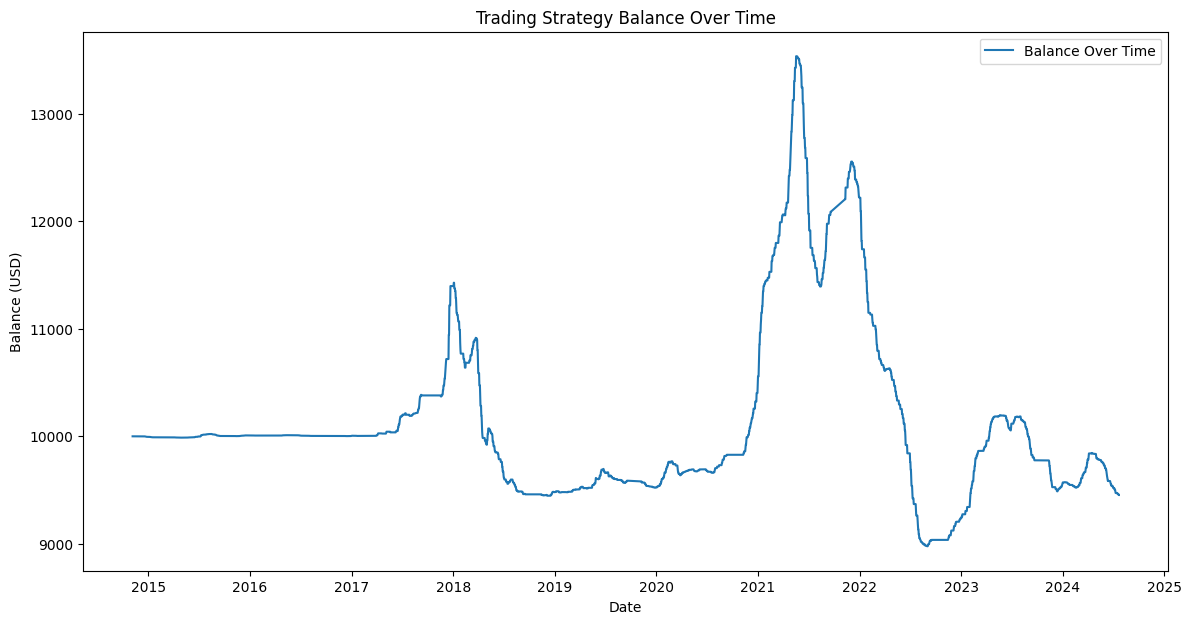

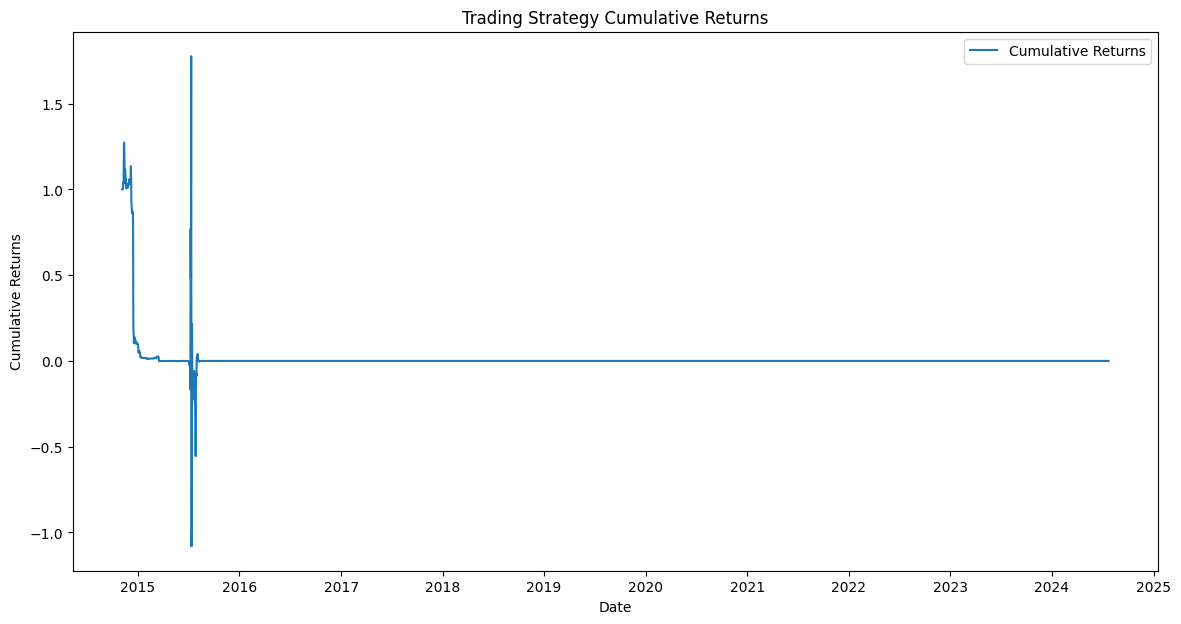

In [141]:
# VISUALIZE TRADING STRATEGY PERFORMANCE
# Plot the balance over time
plt.figure(figsize=(14, 7))
plt.plot(df.index[:env.current_step], env.balance_history[:env.current_step], label='Balance Over Time')
plt.title('Trading Strategy Balance Over Time')
plt.xlabel('Date')
plt.ylabel('Balance (USD)')
plt.legend()
plt.show()

# Calculate the cumulative returns
df['Strategy Returns'] = df['Close'].pct_change() * np.array(env.position_history)
df['Cumulative Returns'] = (1 + df['Strategy Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Cumulative Returns'], label='Cumulative Returns')
plt.title('Trading Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [142]:
# SUMMARY AND REPORTING
# Summary statistics
print(f"Final Balance: {env.balance}")
print(f"Total Trades: {len(env.positions)}")

# Performance metrics
sharpe_ratio = (df['Strategy Returns'].mean() / df['Strategy Returns'].std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio}")

# Generate a report
report = {
    "Final Balance": env.balance,
    "Total Trades": len(env.positions),
    "Sharpe Ratio": sharpe_ratio
}

# Save report to a file
with open('data/trading_report.txt', 'w') as file:
    for key, value in report.items():
        file.write(f"{key}: {value}\n")


Final Balance: 9453.878028392792
Total Trades: 32
Sharpe Ratio: 0.4170264430991848
